# Install Libraries & Dependencies

In [ ]:
!pip install scikit-image==0.19.3
!pip install scikit-image --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 105.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 96.4 MB/s eta 0:00:00
  Created wheel for scikit-image: filename=scikit_image-0.19.3-cp311-cp311-linux_x86_64.whl size=33913067 sha256=6a4d5cf7365925eab10d237b448a5352ce2438ccf1dcd4084ed7f77f5ebcd554
  Stored in directory: /root/.cache/pip/wheels/7b/12/cd/f311cabf9e8708d1e29e9951ee0839fb89b69e1acc60c94927
Successfully built scikit-image
  Attempting uninstall: scikit-image
    Found existing installation: scikit-image 0.25.2
    Uninstalling scikit-image-0.25.2:
      Successfully uninstalled scikit-image-0.25.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.8/14.8 MB 87.2 MB/s eta 0:00:00
  Attempting uninstall: scikit-image
    Found existing installation: scikit-image 0.19.3
    Uninstalling scikit-image-0.19.3:
    

In [ ]:
import os
import numpy as np
import cv2
import glob
import random
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.layers import Activation, BatchNormalization, Multiply, Add
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns


# Data Preprocessing

In [ ]:
import zipfile

zip_file_path = '/content/BraTs18.zip'
extract_path = '/content/BraTs18'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"Files extracted to: {extract_path}")


Files extracted to: /content/BraTs18


In [ ]:
images_dir = "/content/BraTs18/brats18/images"  # Make sure this path is correct
masks_dir = "/content/BraTs18/brats18/masks"   # Make sure this path is correct

In [ ]:
image_files = sorted(glob.glob(os.path.join(images_dir, "image_*.png")))
mask_files = sorted(glob.glob(os.path.join(masks_dir, "mask_*.png")))

In [ ]:
images_dir = "/content/BraTs18/brats18/images"  # Make sure this path is correct
masks_dir = "/content/BraTs18/brats18/masks"   # Make sure this path is correct

   # Print the image files found to debug
image_files = sorted(glob.glob(os.path.join(images_dir, "image_*.png")))
print(f"Found {len(image_files)} image files: {image_files}")

mask_files = sorted(glob.glob(os.path.join(masks_dir, "mask_*.png")))
print(f"Found {len(mask_files)} mask files: {mask_files}")

Found 5042 image files: ['/content/BraTs18/brats18/images/image_1.png', '/content/BraTs18/brats18/images/image_10.png', '/content/BraTs18/brats18/images/image_100.png', '/content/BraTs18/brats18/images/image_1000.png', '/content/BraTs18/brats18/images/image_1001.png', '/content/BraTs18/brats18/images/image_1002.png', '/content/BraTs18/brats18/images/image_1003.png', '/content/BraTs18/brats18/images/image_1004.png', '/content/BraTs18/brats18/images/image_1005.png', '/content/BraTs18/brats18/images/image_1006.png', '/content/BraTs18/brats18/images/image_1007.png', '/content/BraTs18/brats18/images/image_1008.png', '/content/BraTs18/brats18/images/image_1009.png', '/content/BraTs18/brats18/images/image_101.png', '/content/BraTs18/brats18/images/image_1010.png', '/content/BraTs18/brats18/images/image_1011.png', '/content/BraTs18/brats18/images/image_1012.png', '/content/BraTs18/brats18/images/image_1013.png', '/content/BraTs18/brats18/images/image_1014.png', '/content/BraTs18/brats18/images

In [ ]:
assert len(image_files) == len(mask_files), "Mismatch between images and masks!"

In [ ]:
def load_image(file_path):
    image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)  # Read as grayscale
    return image


In [ ]:
def normalize_image(image):
    image = image.astype(np.float32)
    return image / 255.0  # Normalize pixel values to [0, 1]

In [ ]:
def enhance_contrast(image):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    return clahe.apply((image * 255).astype(np.uint8)) / 255.0  # Convert back after applying CLAHE


In [ ]:
def resize_image(image, target_size=(112, 112)):
    return cv2.resize(image, target_size)

In [ ]:
def preprocess_image(file_path, target_size=(112, 112)):
    image = load_image(file_path)
    normalized_image = normalize_image(image)
    enhanced_image = enhance_contrast(normalized_image)
    resized_image = resize_image(enhanced_image, target_size)
    return resized_image

In [ ]:
combined = list(zip(image_files, mask_files))
random.shuffle(combined)
split_idx = int(len(combined) * 0.8)
train_pairs = combined[:split_idx]
val_pairs = combined[split_idx:]

In [ ]:
train_images = [preprocess_image(img_path) for img_path, _ in train_pairs]
train_masks = [load_image(mask_path) for _, mask_path in train_pairs]
val_images = [preprocess_image(img_path) for img_path, _ in val_pairs]
val_masks = [load_image(mask_path) for _, mask_path in val_pairs]

In [ ]:
print(f"Sample preprocessed image shape: {train_images[0].shape}")
print(f"Sample mask shape: {train_masks[0].shape}")

Sample preprocessed image shape: (112, 112)
Sample mask shape: (240, 240)


# Exploratory Data Analysis (EDA)

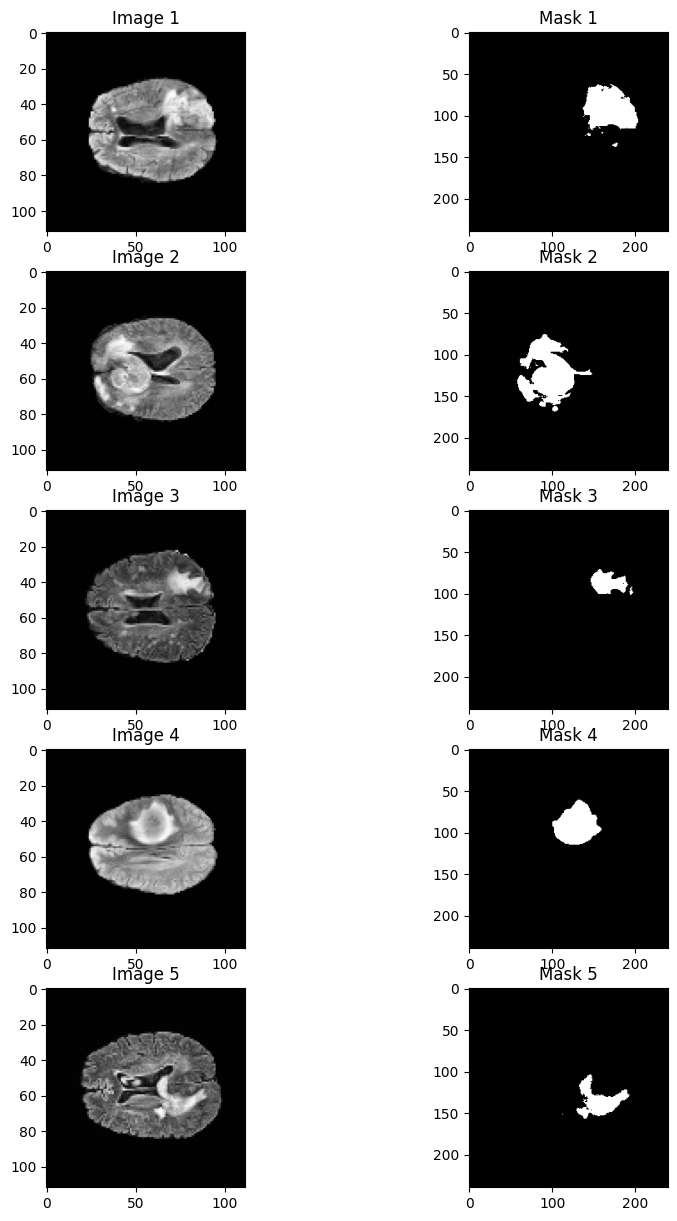

In [ ]:

def display_sample_images(images, masks, n_samples=5):
    fig, axes = plt.subplots(n_samples, 2, figsize=(10, 15))
    for i in range(n_samples):
        axes[i, 0].imshow(images[i], cmap='gray')
        axes[i, 0].set_title(f"Image {i+1}")
        axes[i, 1].imshow(masks[i], cmap='gray')
        axes[i, 1].set_title(f"Mask {i+1}")
    plt.show()

# Display sample images and masks
display_sample_images(train_images, train_masks)

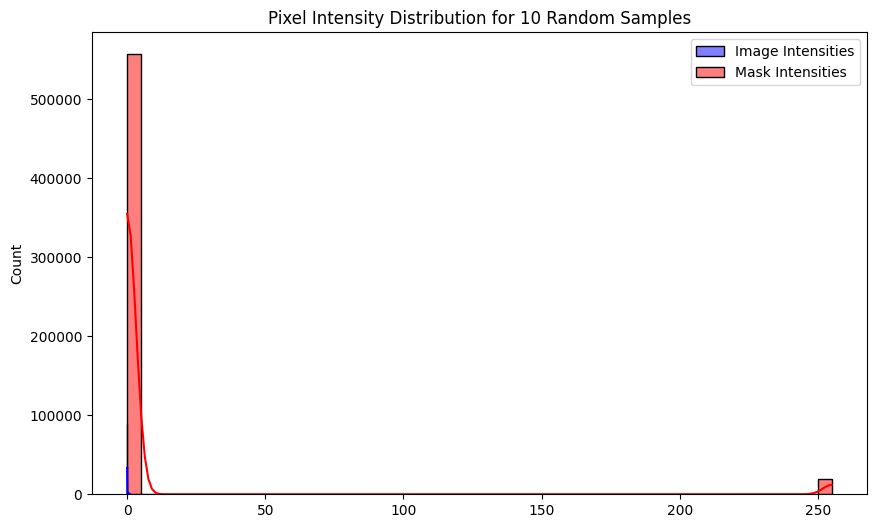

In [ ]:
import random

# Modify plot_pixel_intensity_histogram to accept a sample size
def plot_pixel_intensity_histogram(images, masks, sample_size=10):
    # Select a small random sample of images and masks
    sample_indices = random.sample(range(len(images)), sample_size)

    sample_images = [images[i] for i in sample_indices]
    sample_masks = [masks[i] for i in sample_indices]

    # Extract the pixel intensities from the selected sample
    image_intensity = np.concatenate([img.flatten() for img in sample_images])
    mask_intensity = np.concatenate([mask.flatten() for mask in sample_masks])

    # Plot the histograms for the sampled images and masks
    plt.figure(figsize=(10, 6))
    sns.histplot(image_intensity, bins=50, color='blue', label='Image Intensities', kde=True)
    sns.histplot(mask_intensity, bins=50, color='red', label='Mask Intensities', kde=True)
    plt.legend()
    plt.title(f'Pixel Intensity Distribution for {sample_size} Random Samples')
    plt.show()

# Plot histograms of pixel intensities for a small sample (e.g., 10 samples)
plot_pixel_intensity_histogram(train_images, train_masks, sample_size=10)


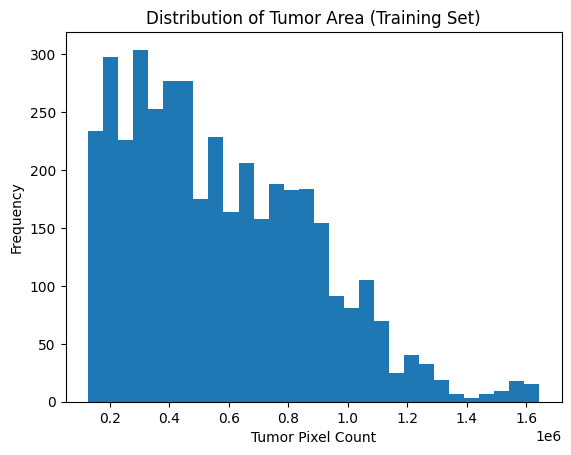

In [ ]:
areas = [np.sum(mask) for mask in train_masks]
plt.hist(areas, bins=30)
plt.title('Distribution of Tumor Area (Training Set)')
plt.xlabel('Tumor Pixel Count')
plt.ylabel('Frequency')
plt.show()


In [ ]:
def preprocess_mask(mask, target_size=(112, 112)):
    resized_mask = cv2.resize(mask, target_size, interpolation=cv2.INTER_NEAREST)
    binarized_mask = np.where(resized_mask > 127, 1, 0).astype(np.float32)
    return binarized_mask


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_datagen = ImageDataGenerator(rotation_range=15,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   zoom_range=0.1)
mask_datagen = ImageDataGenerator(rotation_range=15,
                                  horizontal_flip=True,
                                  vertical_flip=True,
                                  zoom_range=0.1)


In [ ]:
import numpy as np

def check_data_balance(masks):
    combined_masks = np.concatenate([mask.flatten() for mask in masks])
    total_pixels = combined_masks.size
    tumor_pixels = np.sum(combined_masks > 0)

    tumor_percentage = (tumor_pixels / total_pixels) * 100
    print(f"Tumor pixels percentage: {tumor_percentage:.2f}%")


In [ ]:
# Check data balance for training masks
print("Training set balance:")
check_data_balance(train_masks)

# Check data balance for validation masks
print("\nValidation set balance:")
check_data_balance(val_masks)


Training set balance:
Tumor pixels percentage: 3.91%

Validation set balance:
Tumor pixels percentage: 3.84%


# Attention Unet Model

In [ ]:
# Import Libraries
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.layers import Activation, BatchNormalization, Multiply, Add
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanIoU
from sklearn.model_selection import train_test_split
import os
import nibabel as nib
import glob
import cv2
import random


def load_image(file_path):
    image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    return image / 255.0  # normalization to [0, 1]

def load_mask(file_path):
    mask = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    return (mask > 127).astype(np.float32)  # binarize mask

# Paths
images_dir = "/content/BraTs18/brats18/images"
masks_dir = "/content/BraTs18/brats18/masks"

image_files = sorted(glob.glob(f"{images_dir}/image_*.png"))
mask_files = sorted(glob.glob(f"{masks_dir}/mask_*.png"))

images = [cv2.resize(load_image(f), (128,128)) for f in image_files]
masks = [cv2.resize(load_mask(f), (128,128)) for f in mask_files]

images = np.expand_dims(images, axis=-1)
masks = np.expand_dims(masks, axis=-1)

x_train, x_val, y_train, y_val = train_test_split(images, masks, test_size=0.2, random_state=42)

print(f'Training set: {len(x_train)} samples, Validation set: {len(x_val)} samples')


# Attention Gate
def attention_gate(x, gating, inter_shape):
    shape_x = tf.keras.backend.int_shape(x)
    shape_g = tf.keras.backend.int_shape(gating)

    theta_x = Conv2D(inter_shape, (2,2), strides=(2,2), padding='same')(x)
    phi_g = Conv2D(inter_shape, (1,1), padding='same')(gating)

    add_xg = Add()([theta_x, phi_g])
    act_xg = Activation('relu')(add_xg)
    psi = Conv2D(1, (1,1), padding='same', activation='sigmoid')(act_xg)
    psi_up = Conv2DTranspose(1, kernel_size=(2,2), strides=(2,2), padding='same')(psi)
    attn_coefficients = Multiply()([x, psi_up])

    return attn_coefficients

# Attention U-Net Architecture
def attention_unet(input_shape):
    inputs = Input(input_shape)

    # Encoder
    conv1 = Conv2D(64, (3,3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, (3,3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D((2,2))(conv1)

    conv2 = Conv2D(128, (3,3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, (3,3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D((2,2))(conv2)

    conv3 = Conv2D(256, (3,3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, (3,3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D((2,2))(conv3)

    # Bridge
    conv4 = Conv2D(512, (3,3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, (3,3), activation='relu', padding='same')(conv4)

    # Decoder with Attention Gates
    gating_3 = attention_gate(conv3, conv4, 256)
    up1 = Conv2DTranspose(256, (2,2), strides=(2,2), padding='same')(conv4)
    up1 = concatenate([up1, gating_3])
    up1 = Conv2D(256, (3,3), activation='relu', padding='same')(up1)

    gating_2 = attention_gate(conv2, up1, 128)
    up2 = Conv2DTranspose(128, (2,2), strides=(2,2), padding='same')(up1)
    up2 = concatenate([up2, gating_2])
    up2 = Conv2D(128, (3,3), activation='relu', padding='same')(up2)

    gating_1 = attention_gate(conv1, up2, 64)
    up3 = Conv2DTranspose(64, (2,2), strides=(2,2), padding='same')(up2)
    up3 = concatenate([up3, gating_1])
    up3 = Conv2D(64, (3,3), activation='relu', padding='same')(up3)

    outputs = Conv2D(1, (1,1), activation='sigmoid')(up3)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

# Model instantiation
model = attention_unet(input_shape=(128,128,1))
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy', MeanIoU(num_classes=2)])

# Training
history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=10,
    batch_size=8,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=3)
    ]
)

# Evaluation
loss, accuracy, mean_iou = model.evaluate(x_val, y_val)
print(f'Validation Loss: {loss:.4f}, Accuracy: {accuracy:.4f}, Mean IoU: {mean_iou:.4f}')


Training set: 4033 samples, Validation set: 1009 samples
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_43']
Received: inputs=Tensor(shape=(None, 128, 128, 1))
  warnings.warn(msg)


505/505 ━━━━━━━━━━━━━━━━━━━━ 70s 111ms/step - accuracy: 0.9607 - loss: 0.2271 - mean_io_u_1: 0.4820 - val_accuracy: 0.9784 - val_loss: 0.0458 - val_mean_io_u_1: 0.4823 - learning_rate: 1.0000e-04
Epoch 2/10
505/505 ━━━━━━━━━━━━━━━━━━━━ 71s 100ms/step - accuracy: 0.9791 - loss: 0.0457 - mean_io_u_1: 0.4821 - val_accuracy: 0.9839 - val_loss: 0.0328 - val_mean_io_u_1: 0.4823 - learning_rate: 1.0000e-04
Epoch 3/10
505/505 ━━━━━━━━━━━━━━━━━━━━ 82s 100ms/step - accuracy: 0.9844 - loss: 0.0313 - mean_io_u_1: 0.4823 - val_accuracy: 0.9855 - val_loss: 0.0274 - val_mean_io_u_1: 0.4823 - learning_rate: 1.0000e-04
Epoch 4/10
505/505 ━━━━━━━━━━━━━━━━━━━━ 80s 97ms/step - accuracy: 0.9871 - loss: 0.0240 - mean_io_u_1: 0.4817 - val_accuracy: 0.9888 - val_loss: 0.0197 - val_mean_io_u_1: 0.4823 - learning_rate: 1.0000e-04
Epoch 5/10
505/505 ━━━━━━━━━━━━━━━━━━━━ 50s 99ms/step - accuracy: 0.9886 - loss: 0.0201 - mean_io_u_1: 0.4823 - val_accuracy: 0.9890 - val_loss: 0.0191 - val_mean_io_u_1: 0.4823 - lear

# *First_XAI* : (Grad-CAM)

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_43']]
Received: inputs=Tensor(shape=(1, 128, 128, 1))
  warnings.warn(msg)


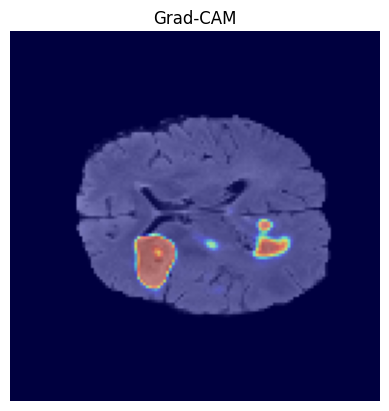

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

def get_gradcam_heatmap(model, image, layer_name):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(np.array([image]))
        loss = predictions[0]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)[0]
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)

    return heatmap

# Example usage:
sample_image = x_val[0]
heatmap = get_gradcam_heatmap(model, sample_image, "conv2d_41")
plt.imshow(sample_image[:,:,0], cmap='gray')
plt.imshow(heatmap, cmap='jet', alpha=0.5)
plt.axis('off')
plt.title("Grad-CAM")
plt.show()


# Second_XAI : (Saliency Map)

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_43']
Received: inputs=Tensor(shape=(1, 128, 128, 1))
  warnings.warn(msg)


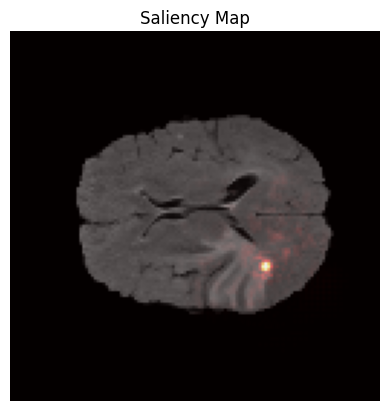

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf

def plot_saliency(model, img):
    img_tensor = tf.convert_to_tensor(img[None, ...], dtype=tf.float32)

    with tf.GradientTape() as tape:
        tape.watch(img_tensor)
        predictions = model(img_tensor)
        loss = tf.reduce_max(predictions)

    gradients = tape.gradient(loss, img_tensor)
    saliency = tf.reduce_max(tf.abs(gradients), axis=-1)[0]

    plt.imshow(img[:,:,0], cmap='gray')
    plt.imshow(saliency, cmap='hot', alpha=0.5)
    plt.axis('off')
    plt.title("Saliency Map")
    plt.show()

# Example usage
plot_saliency(model, x_val[3])


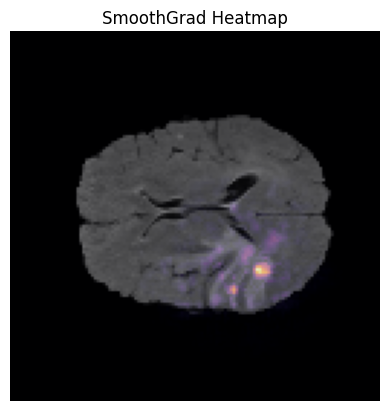

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Function to make SmoothGrad heatmap
def smoothgrad(model, image, noise=0.2, num_samples=20):
    # Turn image into a format TensorFlow likes
    img = tf.convert_to_tensor(image[None, :], dtype=tf.float32)

    # Calculate how much noise to add
    noise_size = noise * (tf.reduce_max(img) - tf.reduce_min(img))

    # Start with zero gradients
    all_grads = tf.zeros_like(img)

    # Add noise and calculate gradients multiple times
    for i in range(num_samples):
        # Add random noise to the image
        noise = tf.random.normal(img.shape, mean=0, stddev=noise_size)
        noisy_img = img + noise

        # Track the noisy image for gradients
        with tf.GradientTape() as tape:
            tape.watch(noisy_img)
            # Get model prediction
            prediction = model(noisy_img)
            # Use the highest prediction score
            score = tf.reduce_max(prediction[0])

        # Get gradients for this noisy image
        grads = tape.gradient(score, noisy_img)
        all_grads += grads

    # Average the gradients
    avg_grads = all_grads[0] / num_samples
    return avg_grads

# Run SmoothGrad on an image (x_val[3] is the image we want)
smooth_grads = smoothgrad(model, x_val[3])

# Show the original image
plt.imshow(x_val[3][:, :, 0], cmap='gray')
# Overlay the SmoothGrad heatmap
plt.imshow(np.abs(smooth_grads[:, :, 0]), cmap='inferno', alpha=0.5)
# Turn off the axes
plt.axis('off')
# Add a title
plt.title("SmoothGrad Heatmap")
# Display the plot
plt.show()

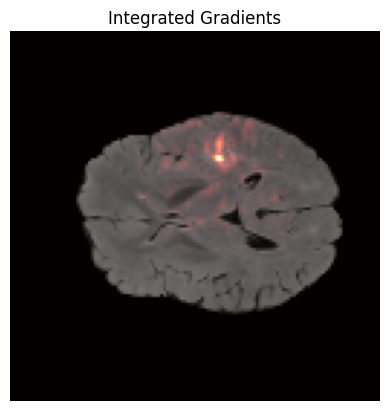

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

def integrated_gradients(model, img, baseline=None, steps=50):
    if baseline is None:
        baseline = np.zeros_like(img).astype(np.float32)

    img = img.astype(np.float32)
    interpolated_imgs = [baseline + (step / steps) * (img - baseline) for step in range(steps + 1)]
    grads_list = []

    for interpolated_img in interpolated_imgs:
        interpolated_img = tf.convert_to_tensor(interpolated_img[None, ...], dtype=tf.float32)

        with tf.GradientTape() as tape:
            tape.watch(interpolated_img)
            pred = model(interpolated_img)
            loss = tf.reduce_max(pred)

        grads = tape.gradient(loss, interpolated_img)
        grads_list.append(grads[0].numpy())

    avg_grads = np.mean(grads_list[:-1], axis=0)
    integrated_grads = (img - baseline) * avg_grads
    return integrated_grads


ig_result = integrated_gradients(model, x_val[6])

plt.imshow(x_val[6][:,:,0], cmap='gray')
plt.imshow(np.abs(ig_result[:,:,0]), cmap='hot', alpha=0.5)
plt.axis('off')
plt.title("Integrated Gradients")
plt.show()
